Using device: cuda:0


100%|██████████| 170M/170M [00:14<00:00, 12.1MB/s]



Model Architecture:
Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (bn_fc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/300], Train Loss: 1.7487, Train Acc: 42.12%, Val Loss: 1.4812, Val Acc: 55.65%, LR: 1.0e-03, Duration: 20.29s
Epoch 1: New best model saved to ./cifar_net_best_final_optimized.pth (Val Loss: 1.4812)
Epoch [2/300], Train Loss: 1.4744, Train Acc: 56.13%, Val Loss: 1.2856, Val Acc: 65.42%, LR: 1.0e-03, Duration: 20.45s
Epoch 2: New best model saved to ./cifar_net_best_final_optimized.pth (Val Loss: 1.2856)
Epoch [3/300], Train Loss: 1.3719, Train Acc: 61.24%, Val Loss: 1.2269, Val Acc: 68.61%, LR: 1.0e-03, Duration: 19.01s
Epoch 3: New best model saved to ./cifar_net_best_final_optimized.pth (Val Loss: 1.2269)
Epoch [4/300], Train Loss: 1.3027, Train Acc: 64.88%, Val Loss: 1.1523, Val Acc: 71.59%, LR: 1.0e-03, Duration: 20.35s
Epoch 4: New best model saved to ./cifar_net_best_final_optimized.pth (Val Loss: 1.1523)
Epoch [5/300], Train Loss: 1.2603, Train Acc: 67.27%, Val Loss: 1.1494, Val Acc: 72.31%, LR: 1.0e-03, Duration: 19.22s
Epoch 5: New best model saved to ./cifar_net_best

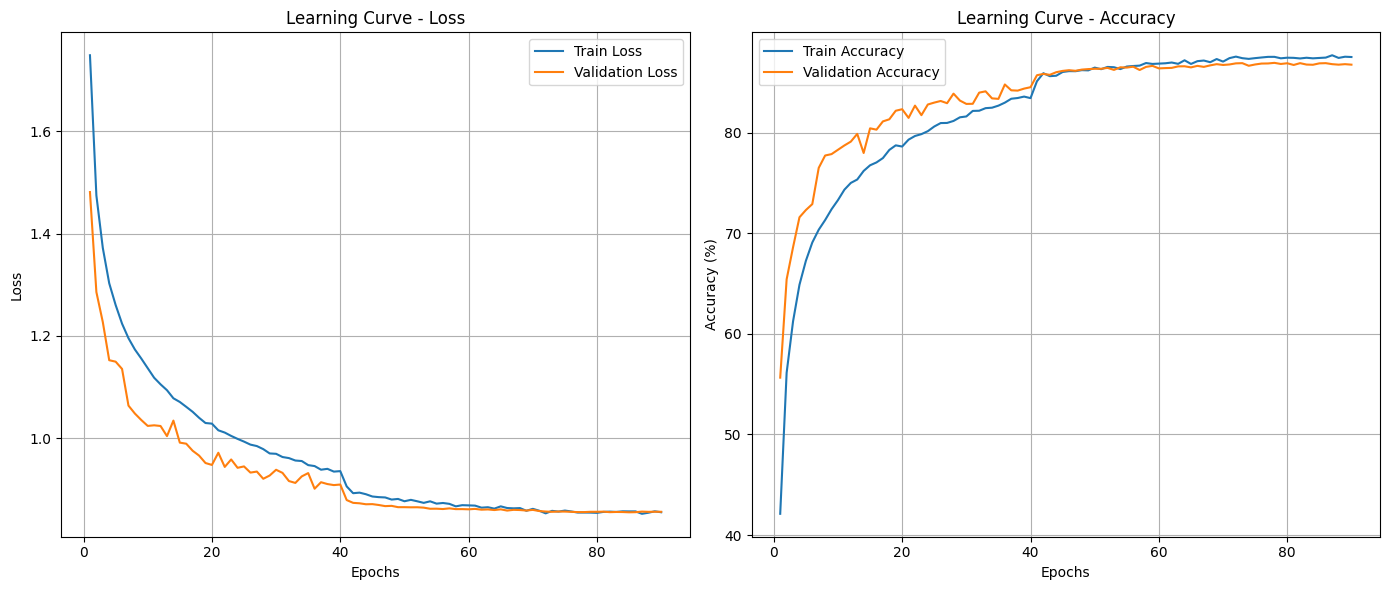

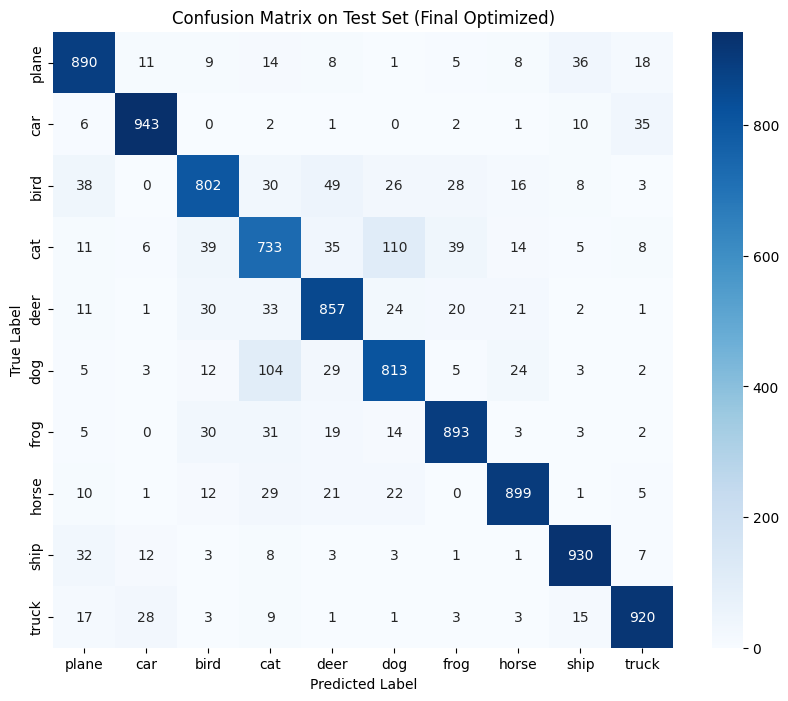

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import multiprocessing
import time
import os

# --- CONFIGURATIONS ---
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PIN_MEMORY = DEVICE.type == 'cuda'
BATCH_SIZE = 128
VALIDATION_SPLIT = 0.2
NUM_WORKERS = 2
LEARNING_RATE = 0.001
WEIGHT_DECAY = 5e-4 # Tăng để chống overfitting
NUM_EPOCHS_INITIAL = 300
EARLY_STOP_PATIENCE = 5 # Giảm để dừng sớm hơn nếu không cải thiện
LR_SCHEDULER_PATIENCE = 3
SEED = 42
DROPOUT_RATE = 0.5
LABEL_SMOOTHING_FACTOR = 0.1 # Sử dụng Label Smoothing

# Set random seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
if DEVICE.type == 'cuda':
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

CLASSES = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# --- DATA TRANSFORMS ---
TRANSFORM_TRAIN = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # Đặt ToTensor() TRƯỚC RandomErasing và Normalize
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2), ratio=(0.3, 3.3), value='random'),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

TRANSFORM_VAL_TEST = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# --- MODEL DEFINITION (Net) ---
class Net(nn.Module):
    def __init__(self, num_classes=len(CLASSES), dropout_rate=DROPOUT_RATE):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# --- HELPER FUNCTIONS ---
def get_dataloaders(batch_size, num_workers, pin_memory, validation_split):
    _ = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
    full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False)

    num_train_val = len(full_train_dataset)
    indices = list(range(num_train_val))
    split = int(np.floor(validation_split * num_train_val))
    np.random.shuffle(indices)
    train_idx, val_idx = indices[split:], indices[:split]

    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=TRANSFORM_TRAIN, download=False)
    val_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=TRANSFORM_VAL_TEST, download=False)

    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler,
                                              num_workers=num_workers, pin_memory=pin_memory)
    valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler,
                                            num_workers=num_workers, pin_memory=pin_memory)

    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=TRANSFORM_VAL_TEST, download=True)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                             num_workers=num_workers, pin_memory=pin_memory)
    return trainloader, valloader, testloader

def train_one_epoch(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    epoch_loss = running_loss / total_train if total_train > 0 else 0.0
    epoch_acc = 100 * correct_train / total_train if total_train > 0 else 0.0
    return epoch_loss, epoch_acc

def validate_one_epoch(model, valloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    epoch_loss = running_loss / total_val if total_val > 0 else 0.0
    epoch_acc = 100 * correct_val / total_val if total_val > 0 else 0.0
    return epoch_loss, epoch_acc

# --- PLOTTING FUNCTIONS ---
def plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs_run):
    epochs_range = range(1, num_epochs_run + 1)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.title('Learning Curve - Loss')
    plt.legend(); plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy (%)'); plt.title('Learning Curve - Accuracy')
    plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()

def plot_confusion_matrix_custom(cm, class_names, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title); plt.ylabel('True Label'); plt.xlabel('Predicted Label')
    plt.show()

# --- MAIN EXECUTION ---
if __name__ == '__main__':
    if os.name == 'nt': # Cho Windows nếu chạy script độc lập
        multiprocessing.freeze_support()

    print(f"Using device: {DEVICE}")

    trainloader, valloader, testloader = get_dataloaders(BATCH_SIZE, NUM_WORKERS, PIN_MEMORY, VALIDATION_SPLIT)

    model = Net(num_classes=len(CLASSES), dropout_rate=DROPOUT_RATE).to(DEVICE)
    print("\nModel Architecture:")
    print(model)

    criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING_FACTOR)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1,
                                  patience=LR_SCHEDULER_PATIENCE, verbose=True)

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_loss = float('inf')
    epochs_no_improve_early_stop = 0
    actual_epochs_run = 0
    best_model_path = './cifar_net_best_final_optimized.pth' # Tên file mới

    print(f"\nStarting Training for up to {NUM_EPOCHS_INITIAL} epochs...")
    for epoch in range(NUM_EPOCHS_INITIAL):
        actual_epochs_run = epoch + 1
        epoch_start_time = time.time()

        train_loss, train_acc = train_one_epoch(model, trainloader, criterion, optimizer, DEVICE)
        val_loss, val_acc = validate_one_epoch(model, valloader, criterion, DEVICE)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        epoch_duration = time.time() - epoch_start_time
        print(f'Epoch [{epoch + 1}/{NUM_EPOCHS_INITIAL}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, '
              f'LR: {optimizer.param_groups[0]["lr"]:.1e}, Duration: {epoch_duration:.2f}s')

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve_early_stop = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"Epoch {epoch+1}: New best model saved to {best_model_path} (Val Loss: {val_loss:.4f})")
        else:
            epochs_no_improve_early_stop += 1

        if epochs_no_improve_early_stop >= EARLY_STOP_PATIENCE:
            print(f'\nEarly stopping triggered after {epoch + 1} epochs due to no improvement in validation loss for {EARLY_STOP_PATIENCE} epochs.')
            break

    print('Finished Training')

    if os.path.exists(best_model_path):
        print(f"Loading best model from {best_model_path} for testing.")
        model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
    else:
        print("No best model was saved. Using current model state.")

    model.eval()
    all_labels_test = []
    all_predicted_test = []
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            all_labels_test.extend(labels.cpu().numpy())
            all_predicted_test.extend(predicted.cpu().numpy())

    test_accuracy = 100 * correct_test / total_test if total_test > 0 else 0.0
    print(f'\nAccuracy of the network on the {total_test} test images: {test_accuracy:.2f}%')

    cm_test = confusion_matrix(all_labels_test, all_predicted_test)
    # Đảm bảo cm_test.sum(axis=1) không có phần tử 0 để tránh lỗi chia cho 0
    class_accuracies = np.zeros(len(CLASSES))
    valid_classes_mask = cm_test.sum(axis=1) > 0
    class_accuracies[valid_classes_mask] = 100 * cm_test.diagonal()[valid_classes_mask] / cm_test.sum(axis=1)[valid_classes_mask]

    print("\nClass-wise accuracy on Test Set:")
    for i, class_name in enumerate(CLASSES):
        if cm_test.sum(axis=1)[i] > 0:
            print(f'Accuracy of {class_name:5s} : {class_accuracies[i]:.2f}%')
        else:
            print(f'Accuracy of {class_name:5s} : N/A (no samples in test set for this class)')


    plot_learning_curves(history['train_loss'], history['val_loss'],
                         history['train_acc'], history['val_acc'], actual_epochs_run)
    plot_confusion_matrix_custom(cm_test, CLASSES, title='Confusion Matrix on Test Set (Final Optimized)')